# Dit (Diffusion Transformer)

Think about DiT as **Translator**:

It translates "Chaos" --> into "Order".

## Mechanical terms

1. Core Idea (Pixels are Words):

Remark: Before we used U-Nets (CNNs). #HMM: worth reading?

Our project:

We take Mel Spectogram tensor(100, 282) and chopped it into 1280 Patches.

So DiT sees those as individual tokens not pixels anymore.

*   **Token 1:** "Top-Left corner of audio."
*   **Token 2:** "The bit next to it."
*   ...
*   **Token 1280:** "Bottom-Right corner."

#### DiT's Inputs:

1. Input A (Noisy MEL)
2. Input B (Image condition) --> the image of an anime girl withh cat for example.
3. Input C (Timestep) --> t = 500

#### DiT's Model

Step A: Self-Attention

Step B: Cross-Attention

Step C: Modulation (AdaLN)

* if t = 1000 (pure noise) --> model makes a wild guesses.
* if t = 10 (almost clean) --> model makes a precise adjustments.

#### DiT's Outputs:

DiT will output a noise [1,1280, 16] with shape as we had for Noisy input.

* Input: Audio + Static
* DiT Output: Static
* Final output: (Audio + Static) - (Predicted Static) = Clean Audio

In [1]:
print(5)

5


# Coding

In [5]:
import torch
import torchaudio
import torch.nn.functional as F
from vocos import Vocos
import matplotlib.pyplot as plt
from IPython.display import Audio, display

TARGET_SR = 24000 
TARGET_SEC = 3.0
TARGET_SAMPLES = int(TARGET_SR * TARGET_SEC)
AUDIO_PATH = "assets/anime.wav"

vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
vocos.eval()

waveform, original_sr = torchaudio.load(AUDIO_PATH)

print(f"Original Loaded: {waveform.shape} @ {original_sr} Hz")

if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)

if original_sr != TARGET_SR:
    print(f"⚠️ Resampling from {original_sr} Hz to {TARGET_SR} Hz...")
    resampler = torchaudio.transforms.Resample(orig_freq=original_sr, new_freq=TARGET_SR)
    waveform = resampler(waveform)

if waveform.shape[1] < TARGET_SAMPLES:
    waveform = F.pad(waveform, (0, TARGET_SAMPLES - waveform.shape[1]))
elif waveform.shape[1] > TARGET_SAMPLES:
    waveform = waveform[:, :TARGET_SAMPLES]
    
print(f"Fixed Waveform: {waveform.shape}")
print(f"Ready for Vocos: {waveform.shape} @ {TARGET_SR} Hz")

# Extract Mel Spectrogram
with torch.no_grad():
    mel_spec = vocos.feature_extractor(waveform)

print(f"Mel Spectrogram Shape: {mel_spec.shape}")

with torch.no_grad():
    reconstructed_audio = vocos.decode(mel_spec)


# display(Audio(waveform.numpy(), rate=TARGET_SR))

display(Audio(reconstructed_audio.numpy(), rate=TARGET_SR))

Original Loaded: torch.Size([1, 47104]) @ 16000 Hz
⚠️ Resampling from 16000 Hz to 24000 Hz...
Fixed Waveform: torch.Size([1, 72000])
Ready for Vocos: torch.Size([1, 72000]) @ 24000 Hz
Mel Spectrogram Shape: torch.Size([1, 100, 282])


/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see

In [21]:
mel_spec = torch.randn(1, 100, 282)
mel_spec = mel_spec.unsqueeze(0)
B, C, H, W = mel_spec.shape


mel_spec.reshape(1, 1, H//2, W//2)

RuntimeError: shape '[1, 1, 50, 141]' is invalid for input of size 28200

In [40]:
import torch
x = torch.randn(4).view(-1)
x.shape
print(x)
print(torch.sqrt(x))

# B, H, W, C, P, D= x.shape
# x = x.reshape(B, -1, C*P)
# print(100 * 200 * 10) 
# x.shape



tensor([-0.8629,  0.6950, -0.7547, -0.5747])
tensor([   nan, 0.8337,    nan,    nan])


In [43]:
import torch
print(torch.sqrt(torch.tensor(0.58)))

tensor(0.7616)


In [21]:
x = torch.randn(5)

x = x[:, None]
print(x.shape) 
print(x)

torch.Size([5, 1])
tensor([[-0.0191],
        [ 0.0745],
        [ 1.2009],
        [-1.2618],
        [-0.3660]])


In [1]:
import torch

x = torch.tensor([5]).float()
print(x)
y = torch.tensor([0.1, 0.3, 0.5])
print(x * y)

tensor([5.])
tensor([0.5000, 1.5000, 2.5000])


In [26]:
import torch

# torch.arange(5)
# tensor([0, 1, 2, 3, 4])
# torch.arange(5) * -0.07
# tensor([-0.0000, -0.0700, -0.1400, -0.2100, -0.2800])
emb = torch.exp(torch.arange(2) * -0.07)
# tensor([1.0000, 0.9324, 0.8694, 0.8106, 0.7558])

t = torch.tensor([500])
emb = t[:, None].float() * emb[None, :]
# tensor([[500.0000, 466.1969, 434.6791, 405.2921, 377.8919]])

# torch.sin(emb)
# tensor([[-0.4678,  0.9462,  0.9083, -0.0267,  0.7838]])


# torch.cos(emb)
# tensor([[-0.8838,  0.3236,  0.4182, -0.9996,  0.6210]])


cs = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
print("cs: ",cs)

lin_l = nn.Linear(4, 2)

# print("lin_l: ",lin_l.weight)
lin_l = lin_l(cs)
# output from lin_l:  tensor([[0.1488, 0.5805]], grad_fn=<AddmmBackward0>)

lin_b_w = nn.Linear(2, 2)
# print("lin_b: ",lin_b)

lin_b_1 = lin_b_w(lin_l)
print("linear: ",lin_b_1)
# linear:  tensor([[0.3181, 0.8975]], grad_fn=<AddmmBackward0>)



act = nn.SiLU()
a_act = act(lin_l)

lin_b_2 = lin_b_w(a_act)
print("with act: ",lin_b_2)
# with act:  tensor([[0.3835, 0.8197]], grad_fn=<AddmmBackward0>)



cs:  tensor([[-0.4678,  0.9462, -0.8838,  0.3236]])
output from lin_l:  tensor([[0.1488, 0.5805]], grad_fn=<AddmmBackward0>)
linear:  tensor([[0.3181, 0.8975]], grad_fn=<AddmmBackward0>)
with act:  tensor([[0.3835, 0.8197]], grad_fn=<AddmmBackward0>)


In [ ]:

# torch.cos(torch.tensor([500]))
# tensor([-0.8838])
# torch.sin(torch.tensor([500]))
# tensor([-0.4678])

tensor([-0.4678])

In [46]:
x = torch.randn(2,1)
print(x)
x.unsqueeze(1)

tensor([[-1.0640],
        [ 0.6048]])


tensor([[[-1.0640]],

        [[ 0.6048]]])

In [17]:
q,v = torch.chunk(torch.randn(1, 50), 2, dim=1)
q.unsqueeze(1).shape 
# v

torch.Size([1, 1, 25])

e torch.Size([1, 1024])


torch.Size([1, 1280, 512])

In [4]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

from vocos import Vocos
from pathlib import Path

### AudioProcessor Processing

class AudioProcessor:
    """
    Handles audio loading, resampling, and Mel spectogram extraction.
    Uses Vocos for consistent Mel generation and reconstruction.
    """
    def __init__(
        self,
        target_sr: int = 24000,
        target_duration: float = 3.0,
        device: str = "cuda"
    ):
        self.target_sr = target_sr
        self.targer_duration = target_duration
        self.target_samples = int(target_sr * target_duration)
        self.device = device

        self.vocos = Vocos.from_pretrained("charactr/vocos-mel-24khz")
        self.vocos.eval()
        self.vocos.to(device)

        self._resamplers = {}

    def _get_resampler(self, orig_sr: int) -> torchaudio.transforms.Resample:
        """Cache resemplers to avoid recreating time"""
        if orig_sr not in self._resamplers:
            self._resamplers[orig_sr] = torchaudio.transforms.Resample(
                orig_freq=orig_sr,
                new_freq=self.target_sr
            )
        return self._resamplers[orig_sr]

    def load_audio(self, audio_path: str) -> torch.Tensor:
        r"""
        Load and preprocess audio file.
        
        Pipe:
            Input: Path to audio file.
            Output: [1, target_samples] waveform at target_sr
        """
        waveform, original_sr = torchaudio.load(audio_path)

        #mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        
        if original_sr != self.target_sr:
            resampler = self._get_resampler(original_sr)
            waveform = resampler(waveform)
        
        if waveform.shape[1] < self.target_samples:
            waveform = F.pad(waveform, (0, self.target_samples - waveform.shape[1]  ))
        elif waveform.shape[1] > self.target_samples:
            waveform = waveform[:, :self.target_samples]
        return waveform
    
    def waveform_to_mel(self, waveform:torch.Tensor) -> torch.Tensor:
        """
        Convert waveform to mel using Vocos.
        
        Pipe:
            Input: [1, samples] or [B, 1, samples]
            Output: [1, 100, frames] or [B,100, frames]
        """
        with torch.no_grad():
            if waveform.dim() == 3:
                waveform = waveform.squeeze(1)
            elif waveform.dim() == 2 and waveform.shape[0] == 1:
                pass
            waveform = waveform.to(self.device)
            mel_spec = self.vocos.feature_extractor(waveform)
        return mel_spec
    
    def mel_to_waveform(self, mel_spec: torch.Tensor) -> torch.Tensor:
        """
        Reconstruct waveform from Mel spectogram using Vocos

        Pipe:
            Input: [B, 100, frames] or [100, frames]
            Output: [B, samples] or [samples]
        """
        with torch.no_grad():
            mel_spec = mel_spec.to(self.devie)
            waveform = self.vocos.decode(mel_spec)

        return waveform
    
    def process_file(self, audio_path: str) -> torch.Tensor:
        """
        Full pipeline: audio file -> Mel Spec.
        Pipe:
            Input: Path to audio file
            Output: [1, 100, frames] Mel spectogram
        """
        waveform = self.load_audio(audio_path)
        mel_spec = self.waveform_to_mel(waveform)

        if mel_spec.dim() == 2:
            mel_spec = mel_spec.unsqueeze(0)
        
        return mel_spec
    

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from pathlib import Path
from typing import Tuple, Optional
import json

class ImageAudioDataset(Dataset):
    """
    Dataset that pairs images with audio files.

    Expected directory structure:
    data/
    ├── pairs.json  (or infer from filenames)
    ├── images/
    │   ├── 001.png
    │   ├── 002.png
    │   └── ...
    └── audio/
        ├── 001.wav
        ├── 002.wav
        └── ...
    """
    def __init__(
        self,
        data_dir: str,
        audio_processor: AudioProcessor,
        image_size: int = 512,
        patch_size: int = 16, 
        pairs_file: Optional[str] = "pairs.json",
        device: str = "cuda"
    ):
        self.data_dir = Path(data_dir)
        self.audio_processor = audio_processor
        self.device = device
        self.patch_size = patch_size

        self.image_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(), # [0, 255] -> [0, 1], HWC -> CHW
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5]) # [-1. 1]
        ])
        
        if pairs_file and (self.data_dir / pairs_file).exists():
            with open(self.data_dir / pairs_file, 'r') as f:
                self.pairs = json.load(f)
        else:
            raise AttributeError(f"Please specify data_dir properly! Current value [{self.data_dir}]")
    
    def _patchify_image(self, image: torch.Tensor) -> torch.Tensor:
        """
        Convert image to patches for transformer input.

        Input: [3, 512, 512]
        Output: [1024, 768] (32 * 32 patches, each 16*16*3)
        """
        C, H, W =image.shape
        P = self.patch_size

        # [3, 512, 512] -> [3, 32, 16, 32, 16]
        x = image.reshape(C, H // P, P, W // P, P)

        # -> [32, 32, 3, 16, 16]
        x = x.permute(1, 3, 0, 2, 4)

        # -> [1024, 768]
        x = x.reshape((H // P) * (W // P), C * P * P)

        return x

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            mel_spec: [1, 100, 280] - Mel spec.
            image_patches: [1024, 768]
        """
        pair = self.pairs[idx]

        image = Image.open(pair["image"]).convert("RGB")
        image = self.image_transform(image) # [3, 512, 512]
        image_patches = self._patchify_image(image) # [1024, 768]

        mel_spec = self.audio_processor.process_file(pair["audio"])

        target_frames = 280 
        if mel_spec.shape[-1] < target_frames:
            mel_spec = F.pad(mel_spec, (0, target_frames - mel_spec.shape[-1]))
        elif mel_spec.shape[-1] > target_frames:
            mel_spec = mel_spec[..., :target_frames]

        return mel_spec, image_patches

def create_dataloader(
    data_dir: str,
    batch_size: int = 4,
    num_workers: int = 4,
    device: str = "cuda"
) -> DataLoader:
    """Factory function to create ready to use dataloader."""
    
    audio_processor = AudioProcessor(
        target_sr=24000,
        target_duration=3.0,
        device=device
    )
    
    dataset = ImageAudioDataset(
        data_dir=data_dir,
        audio_processor=audio_processor,
        image_size=512,
        patch_size=16,
        device=device
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    return dataloader



### MEL_to_Patches block
class MelAdapter:
    def __init__(self, patch_freq=4, patch_time=8):
        #TODO: because we have as input not equally sized MEL_spectogram[1, 100, 256] it's hard to find a good spot with single patch_size. We use 2 patches one for bins and one for freq. I'm curious if that a good idea or not. One option is to try using VAE?
        """        
        patch_freq: patch_size along (100 bins)\n
        patch_time: patch_size along (256 frames)
        """
        self.pf = patch_freq
        self.pt = patch_time
    
    def pack(self, mel_spec):
        """
        Input: [B, 1, 100, 256] (Mel)
        Output: [B, seq_len, patch_size] (DiT input)
        """
        if mel_spec.dim() != 4:
            raise ValueError(f"Expected 4D tensor [B,C,H,W], got {mel_spec.dim()}D")

        B, C, H, W = mel_spec.shape
        PF = self.pf
        PT = self.pt

        # [B, 1, 100, 256] -> [B, C, 50, 2, 141, 2]
        x = mel_spec.reshape(B, C, H//PF, PF, W//PT, PT)
        # [1, 1, 50, 2, 141, 2] -> [1, 50, 141, 1, 2, 2]
        x = x.permute(0, 2, 4, 1, 3, 5)
        x = x.reshape(B, (H//PF) * (W//PT), C*PF*PT)
        return x
    
    def unpack(self, patches, H=100, W=256):
        """
        Input: [Bs, seq_len, C*PF*PT]
        Output: [B, 1, 100, 256] (Mel)
        """
        if patches.dim() != 3:
            raise ValueError(f"Expected 3D Tensor [B,seq,dim], got{patches.dim()}D")
        
        B = patches.shape[0]
        C = 1 
        PF = self.pf
        PT = self.pt

        x = patches.reshape(B, H//PF, W//PT, C, PF, PT)
        x = x.permute(0, 3, 1, 4, 2, 5)
        x = x.reshape(B, C, H, W)
        return x

### Noise Scheduler or Anime Destroyer block
class NoiseScheduler:
    def __init__(self, num_timesteps=1000, device="cuda"):
        self.num_timesteps = num_timesteps
        self.device = device 

        # std linear schedule #TODO: later on implement 'FlowMatchEulerDiscreteScheduler'
        beta_start, beta_end = 0.0001, 0.02
        betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        alphas = 1.0 - betas 
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)

    def add_noise(self, clean_patches, t):
        """
        Input: Clean Patches from adapter [bs, seq_len, 4]
        Output: Noisy Patches [bs, seq_len, 4], The Noise [bs, seq_len, 4]
        """
        noise = torch.randn_like(clean_patches).to(self.device)

        # [500] --> sqrt(0.42%) --> 0.6481 and we convert it to [1,1,1] where first value is == 0.6481 
        sqrt_alpha = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1, 1)
        
        # same but 1.0 - 0.42 = 0.58 --> sqrt(0.58%) --> 0.7616 and we convert it to [1,1,1] where first value is == 0.7616
        sqrt_one_minus_alpha = torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1, 1)
        
        # so it will be ([1,1,1] * clean_patches) + ([1,1,1] * noise)
        noisy_patches = (sqrt_alpha * clean_patches) + (sqrt_one_minus_alpha * noise)

        return noisy_patches, noise

### DiT block
# Here are the 4 ingredients we need to write:
# Timestep Embedder: Turns the integer 500 into a vector.
# AdaLayerNorm: The "Fuel Injector" that injects Time into the layers.
# DiT Block: The actual brain (Attention + MLP).
# Final Model: Puts it all together.

class TimestepEmbedder(nn.Module):
    """
    Input: Time integer (e.g., 500)
    Output: Vector of size `hidden_size`
    Logic: Uses Sine/Cosine waves so the model understands `order`.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.frequency_embedding_size = frequency_embedding_size

    def forward(self, t):
        half_dim = self.frequency_embedding_size // 2 # 128
        emb = math.log(10000) / (half_dim - 1) # 
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None].float() * emb[None, :]
        # [128 sin + 128 cos]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    
        t_emb = self.mlp(emb)
        return t_emb
    
class AdaLayerNorm(nn.Module):
    """
    Adaptive Layer Norm.
    The magic: it looks at the `TIME` and decides how to Scale and Shift the data.
    If t=1000 (Noise), it might scale everything down.
    If t=0 (Clean), it might scale everything up.
    """
    def __init__(self, hidden_size):
        super().__init__()
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.silu = nn.SiLU()

        self.linear = nn.Linear(hidden_size, 2 * hidden_size, bias=True)

    def forward(self, x, t_emb):
        emb = self.linear(self.silu(t_emb))
        print("e", emb.shape)
        scale, shift = torch.chunk(emb, 2, dim=1)

        scale = scale.unsqueeze(1)
        shift = shift.unsqueeze(1)

        x = self.norm(x)
        x = x * (1 + scale) + shift
        return x 


class DiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()

        # self-attention for mel
        self.norm1 = AdaLayerNorm(hidden_size)
        self.attn1 = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)

        # cross-attention for condition-image
        self.norm2 = AdaLayerNorm(hidden_size)
        self.attn2 = nn.MultiheadAttention(hidden_size, num_heads, batch_first=True)

        self.norm3 = AdaLayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Linear(hidden_size * 4,  hidden_size)
        )
    
    def forward(self, x, context, t_emb):
        """
        x: Mel Features [batch, seq_len, hidden]
        context: Image Features [batch, ???, hidden]
        t_emb: Time-step embedding [batch, hidden]
        """
        ### Self-attention
        x_norm = self.norm1(x, t_emb)
        attn_output, _ = self.attn1(x_norm, x_norm, x_norm)
        x = x + attn_output # Residual
        
        ### Cross-attention
        x_norm = self.norm2(x, t_emb)
        attn_output, _ = self.attn2(query=x_norm, key=context, value=context)
        x = x + attn_output # Residual

        ### MLP
        x_norm = self.norm3(x, t_emb)
        mlp_output = self.mlp(x_norm)
        x = x + mlp_output # Residual

        return x 

class SimpleDiT(nn.Module):
    def __init__(
            self,
            mel_input_dim=32, # patch_freq(4) * patch_time(8) * channels(1)
            img_input_dim=768, # 16 * 16 * 3
            hidden_size=512,
            mel_seq_len=875, # (100/4) * (280/8) = 25 * 35
            img_seq_len=1024, # (512/16) * (512/16) = 32 * 32
            num_layers=6,
            num_heads=8):
        super().__init__()

        self.mel_seq_len = mel_seq_len
        self.img_seq_len = img_seq_len

        ### Adapters for Mel and Image 
        self.mel_proj = nn.Linear(mel_input_dim, hidden_size)
        self.img_proj = nn.Linear(img_input_dim, hidden_size)

        ### Time Embedder
        self.time_embed = TimestepEmbedder(hidden_size)

        ### Pos Embeddings
        self.pos_embed_mel = nn.Parameter(torch.zeros(1, mel_seq_len, hidden_size))
        self.pos_embed_img = nn.Parameter(torch.zeros(1, img_seq_len, hidden_size))

        ### Stack of Blocks
        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])

        ### Output Projection
        self.final_norm = AdaLayerNorm(hidden_size)
        self.final_linear = nn.Linear(hidden_size, mel_input_dim)

    def forward(self, x, context, t):
        """
        x: Noisy Mel Patches [B, 875, 32]
        context: Image Patches [B, 1024, 768]
        t: Timesteps [B]

        Returns: Predicted Noise [B, 875, 32]
        """

        ### Input preparaiton
        x = self.mel_proj(x) # [B, 875, 32] -> [B, 875, 512]
        context = self.img_proj(context) # [B, 1024,768] -> [B, 1024, 512]

        x = x + self.pos_embed_mel
        context = context + self.pos_embed_img

        t_emb = self.time_embed(t) #[B] -> [B, 512]

        for block in self.blocks:
            x = block(x, context, t_emb)
        
        x = self.final_norm(x, t_emb)
        prediction = self.final_linear(x) # [B, 875, 512] -> [B, 875, 32]

        return prediction


DEVICE = 'cuda'
BATCH_SIZE = 2

dataloader = create_dataloader(
    data_dir="./data",
    batch_size=BATCH_SIZE,
    device=DEVICE
)

mel_adapter = MelAdapter(patch_freq=4, patch_time=8)
noise_scheduler = NoiseScheduler(num_timesteps=1000, device=DEVICE)

model = SimpleDiT(
    mel_input_dim=32,
    img_input_dim=768,
    hidden_size=256,
    mel_seq_len=875,
    img_seq_len=1024,
    num_layers=2,
    num_heads=4
).to(DEVICE) # .cuda() vs to.("cuda") what is the difference?

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(100):
    for batch_idx, (mel_spec, image_patches) in enumerate(dataloader):
        # mel_spec: [B, 1, 100, 280]
        # image_patches: [B, 1024, 768]

        mel_spec = mel_spec.to(DEVICE)
        image_patches = image_patches.to(DEVICE)

        clean_patches = mel_adapter.pack(mel_spec)

        t = torch.randint(0, 1000, (BATCH_SIZE,), device=DEVICE).to(DEVICE)

        noisy_patches, noise = noise_scheduler.add_noise(clean_patches, t)

        predicted_noise = model(noisy_patches, image_patches, t)

        loss = F.mse_loss(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss {loss.item():.4f}")

/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_1050187/1271432029.py", line 199, in __getitem__
    mel_spec = self.audio_processor.process_file(pair["audio"])
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1050187/1271432029.py", line 105, in process_file
    mel_spec = self.waveform_to_mel(waveform)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1050187/1271432029.py", line 79, in waveform_to_mel
    waveform = waveform.to(self.device)
               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vladimir_albrekht/projects/img_to_spec/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py", line 398, in _lazy_init
    raise RuntimeError(
RuntimeError: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method


In [3]:
pwd

'/home/vladimir_albrekht/projects/img_to_spec'

In [1]:

import json
from pathlib import Path
import shutil

def create_test_dataset(
    image_path: str,
    audio_path: str,
    output_dir: str = "./data",
    num_copies: int = 16  # Create fake "dataset" by duplicating
):
    """
    Create a test dataset from a single image-audio pair.
    For real training, you'd have actual different pairs!
    """
    output_dir = Path(output_dir)
    images_dir = output_dir / "images"
    audio_dir = output_dir / "audio"
    
    # Create directories
    images_dir.mkdir(parents=True, exist_ok=True)
    audio_dir.mkdir(parents=True, exist_ok=True)
    
    pairs = []
    
    # Get file extensions
    img_ext = Path(image_path).suffix
    audio_ext = Path(audio_path).suffix
    
    for i in range(num_copies):
        # Copy files with numbered names
        new_img_path = images_dir / f"{i:03d}{img_ext}"
        new_audio_path = audio_dir / f"{i:03d}{audio_ext}"
        
        shutil.copy(image_path, new_img_path)
        shutil.copy(audio_path, new_audio_path)
        
        pairs.append({
            "image": str(new_img_path.absolute()),
            "audio": str(new_audio_path.absolute())
        })
    
    # Save pairs.json
    pairs_file = output_dir / "pairs.json"
    with open(pairs_file, 'w') as f:
        json.dump(pairs, f, indent=2)
    
    print(f"✓ Created {num_copies} pairs in {output_dir}")
    print(f"✓ Saved pairs.json at {pairs_file}")
    
    return pairs


# Run it!
pairs = create_test_dataset(
    image_path="/home/vladimir_albrekht/projects/img_to_spec/assets/animeha.jpg",
    audio_path="/home/vladimir_albrekht/projects/img_to_spec/assets/anime.wav",
    output_dir="./data",
    num_copies=16
)

print(json.dumps(pairs[:2], indent=2))  # Preview first 2 pairs


✓ Created 16 pairs in data
✓ Saved pairs.json at data/pairs.json
[
  {
    "image": "/home/vladimir_albrekht/projects/img_to_spec/data/images/000.jpg",
    "audio": "/home/vladimir_albrekht/projects/img_to_spec/data/audio/000.wav"
  },
  {
    "image": "/home/vladimir_albrekht/projects/img_to_spec/data/images/001.jpg",
    "audio": "/home/vladimir_albrekht/projects/img_to_spec/data/audio/001.wav"
  }
]


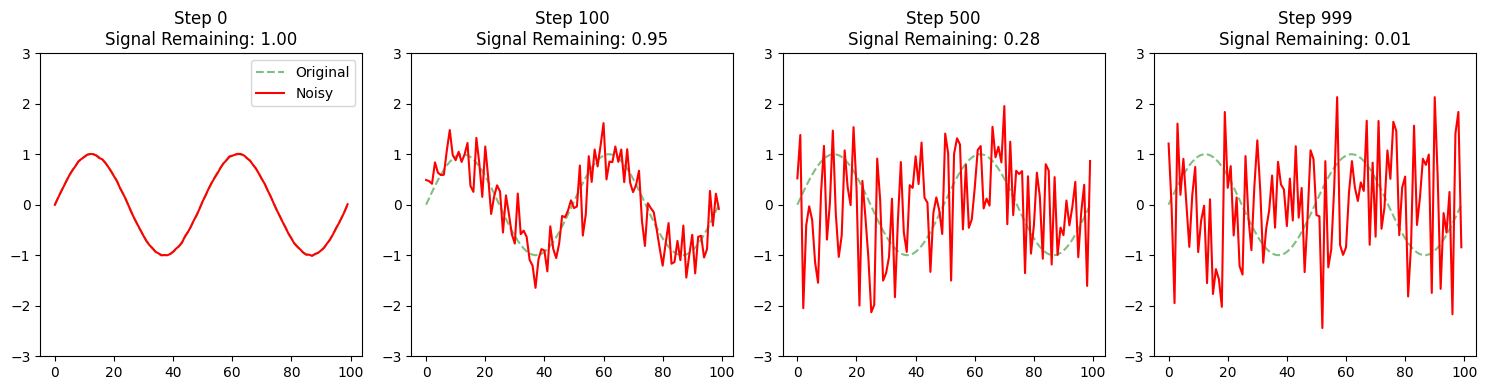

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1. DEFINE THE SCHEDULER CLASS (Your Code)
class NoiseScheduler:
    def __init__(self, num_timesteps=1000, device="cpu"):
        self.num_timesteps = num_timesteps
        self.device = device 
        beta_start, beta_end = 0.0001, 0.02
        betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        alphas = 1.0 - betas 
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)

    def add_noise(self, clean_patches, t):
        noise = torch.randn_like(clean_patches).to(self.device)
        # Reshape t to allow indexing
        t = t.long()
        
        # Get coefficients
        sqrt_alpha = torch.sqrt(self.alphas_cumprod[t]).view(-1, 1)
        print(sqrt_alpha)
        sqrt_one_minus_alpha = torch.sqrt(1.0 - self.alphas_cumprod[t]).view(-1, 1)

        noisy_patches = (sqrt_alpha * clean_patches) + (sqrt_one_minus_alpha * noise)
        return noisy_patches

# 2. CREATE DUMMY DATA (A Clean Sine Wave)
# Shape: [1, 100] (Batch 1, 100 points)
x = torch.linspace(0, 4*np.pi, 100).unsqueeze(0)
clean_data = torch.sin(x)

# 3. SETUP
scheduler = NoiseScheduler(num_timesteps=1000)
steps_to_show = [0, 100, 500, 999]

# 4. VISUALIZE THE DESTRUCTION
plt.figure(figsize=(15, 4))

for i, t_step in enumerate(steps_to_show):
    # Create a batch of 1 containing the specific timestep
    t = torch.tensor([t_step])
    
    # Add Noise
    noisy_data = scheduler.add_noise(clean_data, t)
    
    # Plot
    plt.subplot(1, 4, i+1)
    plt.plot(clean_data[0].numpy(), label="Original", color='green', linestyle='--', alpha=0.5)
    plt.plot(noisy_data[0].numpy(), label="Noisy", color='red')
    
    # Calculate Signal Strength for title
    sig_strength = torch.sqrt(scheduler.alphas_cumprod[t_step]).item()
    plt.title(f"Step {t_step}\nSignal Remaining: {sig_strength:.2f}")
    plt.ylim(-3, 3) # Keep scale consistent
    if i == 0: plt.legend()

plt.tight_layout()
plt.show()

The key insight: permute doesn't change data, only how dimensions are organized - like rotating a Rubik's cube without changing the colors.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MelAdapter:
    def __init__(self, patch_size=2):
        self.p = patch_size

    def pack(self, mel_spec):
        """
        Input:  [Batch, 1, 100, 282] (The Mel)
        Output: [Batch, Sequence_Len, 4] (The DiT Input)
        """
        # 1. Pad if necessary (Dimensions must be divisible by patch_size)
        # 100 is divisible by 2. 282 is divisible by 2. We are good.
        # If not, we would F.pad here.
        
        B, C, H, W = mel_spec.shape
        P = self.p
        
        # 2. Reshape into patches
        # [B, C, H//P, P, W//P, P]
        x = mel_spec.reshape(B, C, H//P, P, W//P, P)
        
        # 3. Permute to group pixels
        # [B, H//P, W//P, C, P, P]
        x = x.permute(0, 2, 4, 1, 3, 5)
        
        # 4. Flatten
        # [B, Seq_Len, C*P*P] -> [B, 7050, 4]
        # (50 * 141 = 7050 patches)
        x = x.reshape(B, -1, C*P*P)
        
        return x

    def unpack(self, patches, target_height, target_width):
        """
        Input:  [Batch, Seq_Len, 4]
        Output: [Batch, 1, 100, 282]
        """
        B = patches.shape[0]
        P = self.p
        C = 1 # We know Mel is 1 channel
        
        H_grid = target_height // P
        W_grid = target_width // P
        
        # Reshape back
        x = patches.reshape(B, H_grid, W_grid, C, P, P)
        x = x.permute(0, 3, 1, 4, 2, 5)
        x = x.reshape(B, C, target_height, target_width)
        
        return x

# Test it
adapter = MelAdapter(patch_size=2)
dummy_mel = torch.randn(1, 1, 100, 282)
patches = adapter.pack(dummy_mel)
print(f"Mel: {dummy_mel.shape} -> Patches: {patches.shape}")

Mel: torch.Size([1, 1, 100, 282]) -> Patches: torch.Size([1, 7050, 4])
